## Predicción de ACV - Aprendizaje de Máquina 1

Autores: María Fabiana Cid y Gonzalo Gabriel Fernandez, Universidad de Buenos Aires

Link a repositorio en GitHub: https://github.com/gonzafernan/ceia-amq1

### Objetivo

Según la Organización Mundial de la Salud (OMS), el accidente cerebrovascular (ACV) es la segunda causa principal de muerte a nivel mundial, siendo responsable de aproximadamente el 11% del total de muertes.

En el presente trabajo se analiza el conjunto de datos titulado [Stroke Prediction](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) publicado en Kaggle.

Se plantea como objetivo **predecir**, conociendo determinadas caracteristicas fisiológicas y sociales del paciente, la posibilidad de que tenga un accidente cardiovascular.

### Desarrollo

Primero se realiza la recolección de datos y su preparación para ser analizados. Luego, se realiza una ingenieria de features, el entrenamiento de distintos modelos y su evaluación.

Se trata de un problema de clasificación binaria, por lo que se consideraron y estudiaron los siguientes algoritmos:

- Regresión logística
- Clasificador KNN
- Support Vector Machine (SVM)
- Árbol de decisión
- Random Forest

Además, se entrenaron modelos de redes neuronales (aprendizaje profundo con la libreria Torch). También se incorporaron herramientas de aprendizaje no supervisado, como Tsne para reducción de dimensionalidad y clustering con K-means.

### Conclusión

De todos los algoritmos clásicos de aprendizaje de máquina estudiados, el de mejor desempeño fue el Random Forest considerando los siguientes indicadores:

- Accuracy: 0.9712
- Precisión: 0.9788
- Recall: 0.9645
- F1-score: 0.9716

Por lo que un modelo con Random Forest resulta adecuado para resolver el problema propuesto. Al analizar las métricas se dio prioridad a no tener falsos negativos por sobre falsos positivos siendo que involucra la salud de las personas.

### Información de los atributos del dataset utilizado

- id: identificador único
- gender: "Male" (Hombre), "Female" (Mujer) o "Other" (Otro)
- age: edad del paciente
- hypertension: 0 si el paciente no tiene hipertensión, 1 si el paciente tiene hipertensión
- heart_disease: 0 si el paciente no tiene enfermedades cardíacas, 1 si el paciente tiene una enfermedad cardíaca
- ever_married: "No" o "Yes" (No o Sí)
- work_type: "children" (niños), "Govt_job" (empleo gubernamental), "Never_worked" (nunca trabajó), "Private" (sector privado) o "Self-employed" (autónomo)
- Residence_type: "Rural" o "Urban" (Rural o Urbano)
- avg_glucose_level: nivel promedio de glucosa en sangre
- bmi: índice de masa corporal
- smoking_status: "formerly smoked" (fumó anteriormente), "never smoked" (nunca fumó), "smokes" (fuma) o "Unknown" (desconocido)
- stroke: 1 si el paciente sufrió un accidente cerebrovascular, 0 si no

### Dependencias

Para modelos de aprendizaje de máquina clásicos:

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

Para redes neuronales:

In [184]:
# for feed-forward neural network
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import torch.nn
import keras

In [185]:
from ipywidgets import IntProgress
from IPython.display import display

Cargar el dataset "Stroke Prediction". Se encuentra disponible el script `download_dataset.sh` para su descarga desde Kaggle.

In [186]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.set_index("id", inplace=True)
print("Número de observaciones:", len(df))
df.head(2)

Número de observaciones: 5110


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [187]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Imputación de datos duplicados

In [188]:
print("Número de datos duplicados:", df.duplicated().sum())

Número de datos duplicados: 0


### Imputación de datos faltantes

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Se puede observar que la única variable con valores nulos es *bmi*.

Se asume que la razón por la cual faltan datos es completamente aleatoria (MCAR).

<Axes: title={'center': 'BMI NAN'}, xlabel='stroke', ylabel='count'>

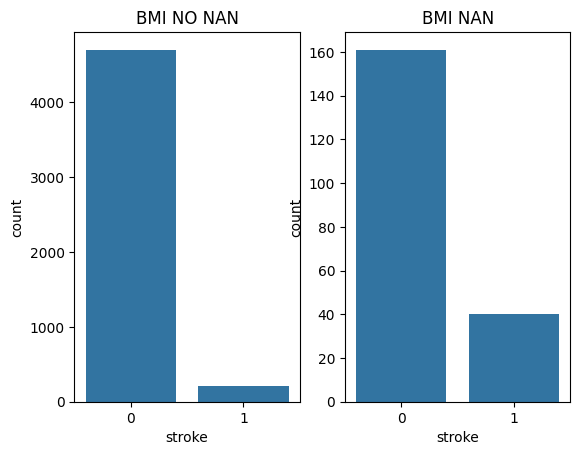

In [190]:
df_no_nan = df.dropna(axis="index", how="any")

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].set_title("BMI NO NAN")
sns.countplot(data=df_no_nan, x="stroke", ax=axs[0])
axs[1].set_title("BMI NAN")
sns.countplot(data=df[df.isnull().any(axis=1)], x="stroke", ax=axs[1])

Por el momento, se eliminan las filas con valores faltantes de bmi. Si en el modelo no se utiliza la variable bmi, es importante no eliminar los datos.

In [191]:
df.dropna(axis="index", how="any", inplace=True)

### Análisis de distribución de los datos
#### Variables categóricas

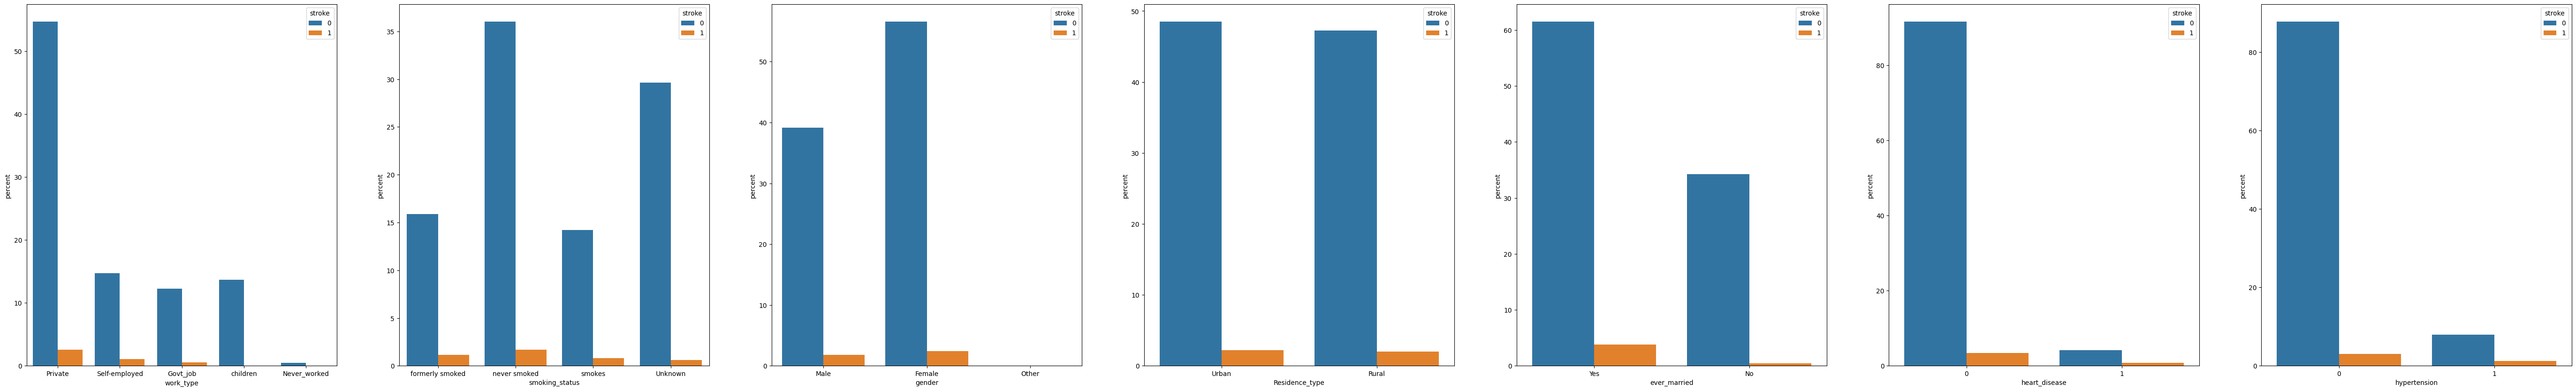

In [192]:
LABELS = [
    "work_type",
    "smoking_status",
    "gender",
    "Residence_type",
    "ever_married",
    "heart_disease",
    "hypertension",
]
fig, axs = plt.subplots(nrows=1, ncols=len(LABELS))
fig.set_size_inches(len(LABELS) * 10, 10)
for ax, label in zip(axs, LABELS):
    sns.countplot(df, x=label, hue="stroke", stat="percent", ax=ax)

#### Variables continuas

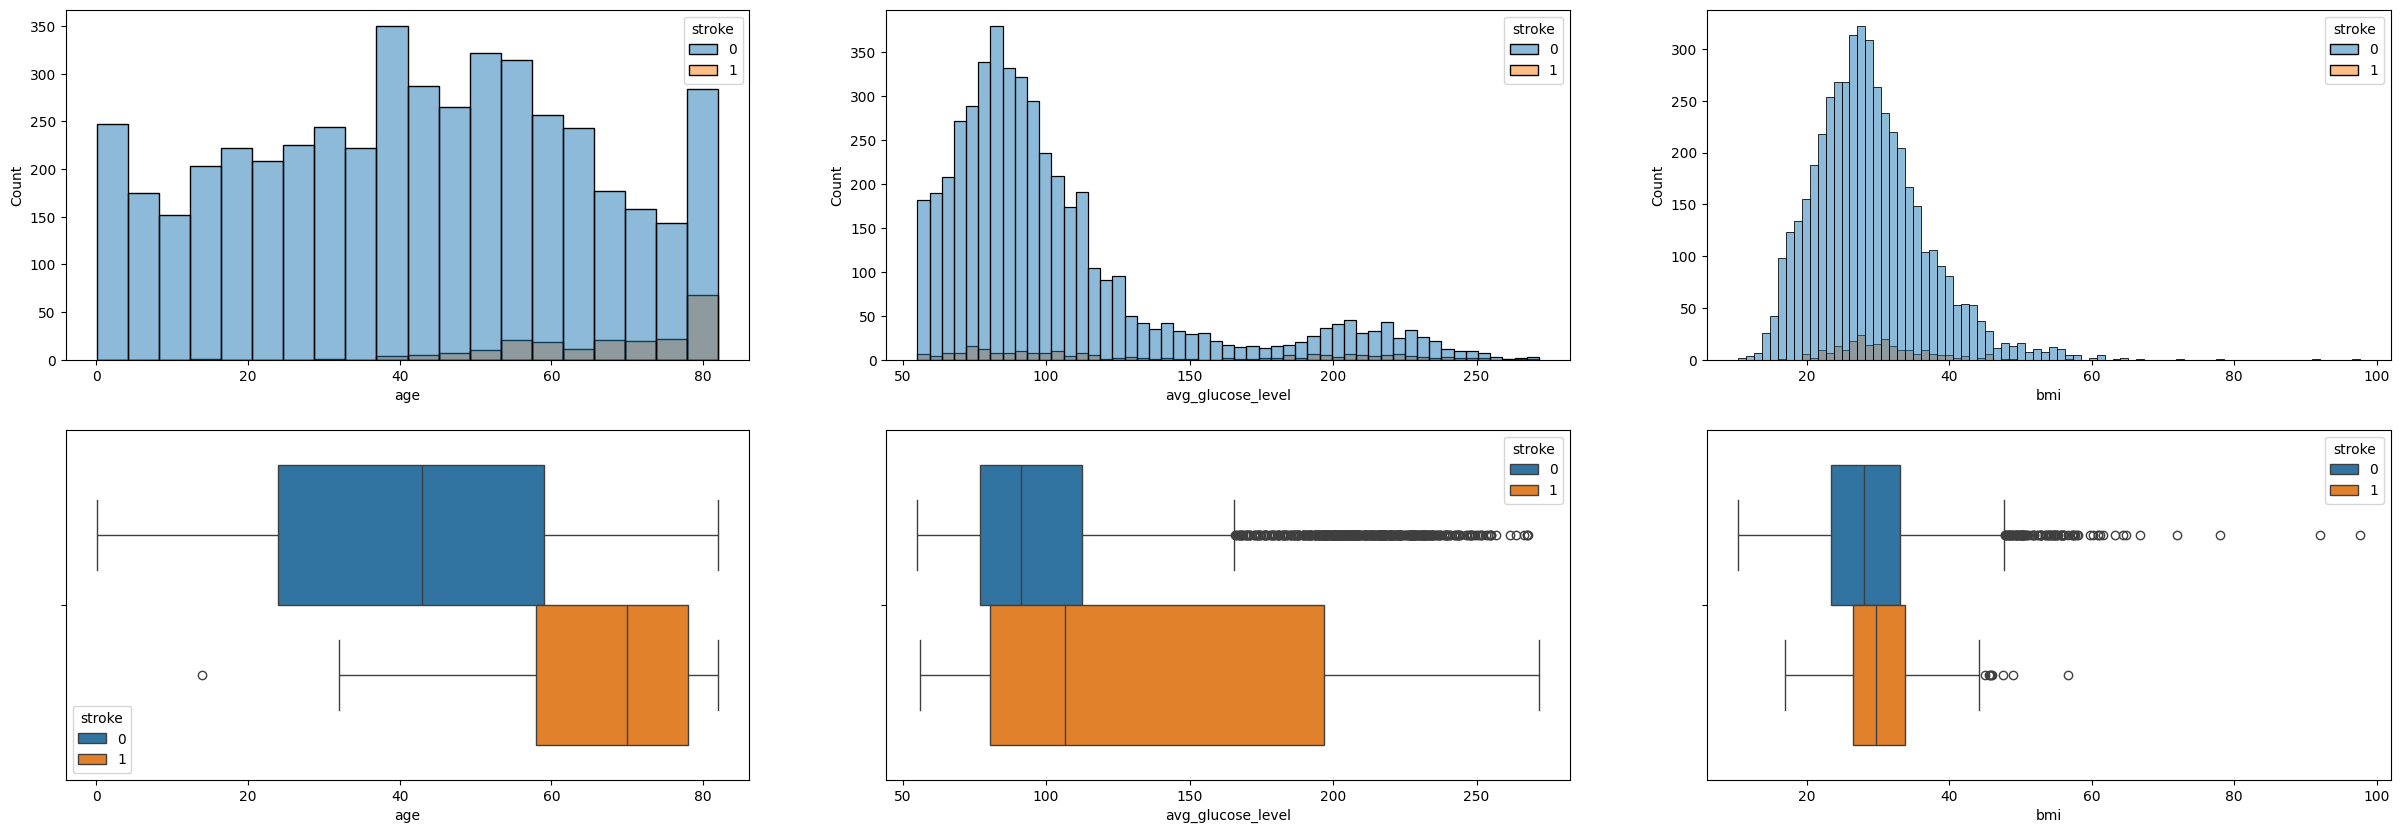

In [193]:
LABELS = ["age", "avg_glucose_level", "bmi"]
fig, axs = plt.subplots(nrows=2, ncols=len(LABELS))
fig.set_size_inches(len(LABELS) * 10, 10)
for ax_hist, ax_box, label in zip(axs[0], axs[1], LABELS):
    sns.histplot(df, x=label, hue="stroke", ax=ax_hist)
    sns.boxplot(df, x=label, hue="stroke", ax=ax_box)

- En la distribución de la edad se puede observar como hay una claro aumento en derrames cerebrales al aumentar la edad. Por el otro lado, el nivel de glucosa y indice de masa corporal paece tener la misma distribución para casos con y sin derrame cerebral.
- En la distribución del índice de masa corporal se observa una gran cantidad de outliers.

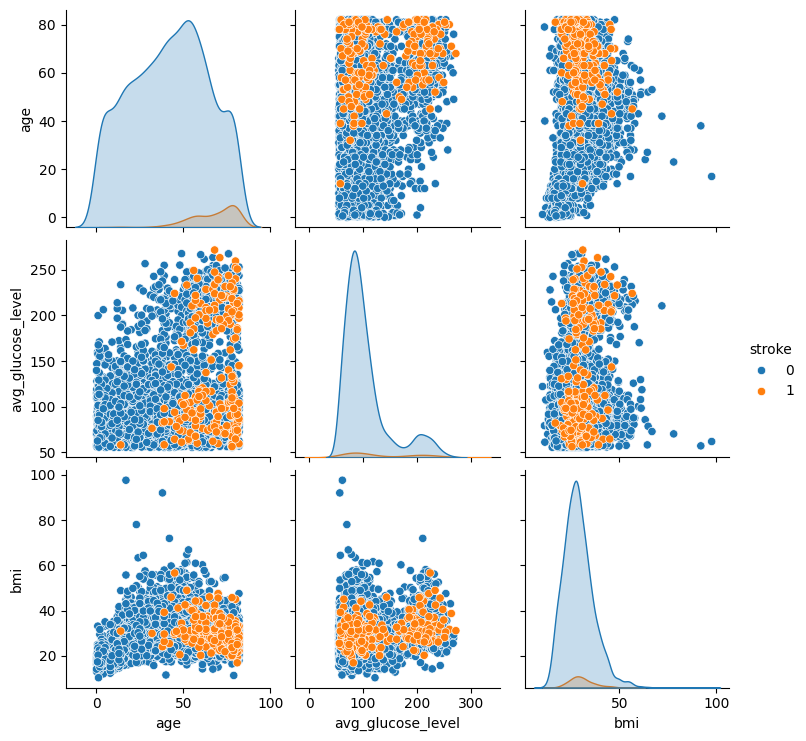

In [194]:
sns.pairplot(
    df.drop(["hypertension", "heart_disease"], axis=1).sort_values("stroke"),
    hue="stroke",
)

### Análisis de correlación de las features

<Axes: title={'center': 'Map de calor con correlación de variables'}>

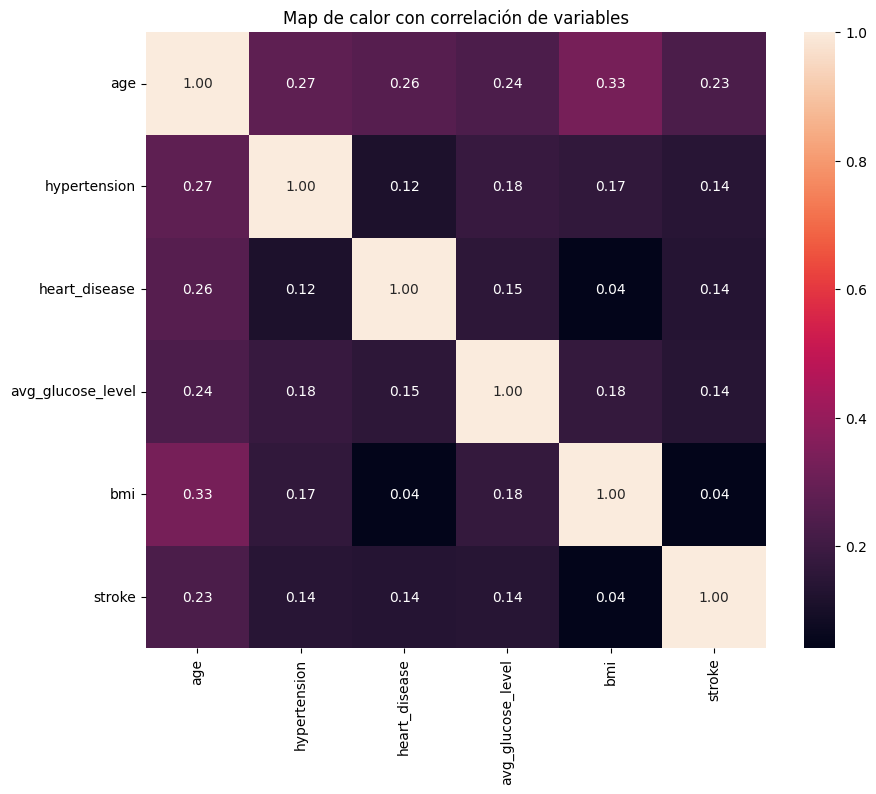

In [195]:
number = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
plt.title("Map de calor con correlación de variables")
sns.heatmap(number.corr(), annot=True, fmt=".2f")

Se puede observar correlación entre la edad y el resto de las variables.

### Análisis de distribución de los datos

### Transformación de los datos
Transformación de variables categóricas. Posible mediante **One-Hot encoding** dada que la cantidad de categorías es relativamente baja y con poca probabilidad de cambiar/extenderse en el futuro.

In [196]:
# Cathegoric variables transformation
print("Applying One-Hot encoding to:")
for label, to_drop in [
    ("gender", "Other"),
    ("ever_married", "No"),
    ("work_type", "children"),
    ("Residence_type", "Rural"),
    ("smoking_status", "Unknown"),
]:
    unique_values = df[label].unique()
    print(label + ":", unique_values)
    prefix = "is" if len(unique_values) > 2 else label
    one_hot = pd.get_dummies(data=df[label], prefix=prefix).drop(
        prefix + "_" + to_drop if prefix else to_drop, axis=1
    )
    df.drop(label, axis=1, inplace=True)
    df = df.join(one_hot)
df.head()

Applying One-Hot encoding to:
gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_Female,is_Male,ever_married_Yes,is_Govt_job,is_Never_worked,is_Private,is_Self-employed,Residence_type_Urban,is_formerly smoked,is_never smoked,is_smokes
id,,,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.6,1,False,True,True,False,False,True,False,True,True,False,False
31112,80.0,0,1,105.92,32.5,1,False,True,True,False,False,True,False,False,False,True,False
60182,49.0,0,0,171.23,34.4,1,True,False,True,False,False,True,False,True,False,False,True
1665,79.0,1,0,174.12,24.0,1,True,False,True,False,False,False,True,False,False,True,False
56669,81.0,0,0,186.21,29.0,1,False,True,True,False,False,True,False,True,True,False,False


Clases imbalanceadas: De [Datasets: Imbalanced datasets](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets), hay gran diferencia entre las clases.

In [197]:
stroke_count = df.stroke.value_counts()
print(stroke_count, len(df))
print(f"Degree of imbalance: {stroke_count[1] / len(df) * 100:0.2f}%")

stroke
0    4700
1     209
Name: count, dtype: int64 4909
Degree of imbalance: 4.26%


### Entrenamiento de diferentes modelos ignorando desbalanceo
Separación del dataset en variable target y variables de entrada.

In [198]:
X = df.drop("stroke", axis=1).values
y = df["stroke"].values

Escalamiento de las variables de entrada. `RobustScaler` elimina la mediana y escala según el rango intercuartílico.

In [199]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

División en set de entrenamiento y de evaluación.

In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

A continuación, los modelos a entrenar siguiendo el orden en que se estudiaron en la materia "Aprendizaje de Máquina I":

In [201]:
class StrokePredictionModel:
    """Machine learning model for stroke prediction"""

    def __init__(self, name: str, model: ClassifierMixin) -> None:
        self.name = name
        self.model = model
        self.accuracy = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1_score = 0.0
        self.confusion_matrix = None

In [202]:
predictors = [
    StrokePredictionModel(
        name="Regresión Logística", model=LogisticRegression(max_iter=1000)
    ),
    StrokePredictionModel(
        name="Clasificador KNN", model=KNeighborsClassifier(n_neighbors=3)
    ),
    StrokePredictionModel(
        name="Support Vector Machine", model=SVC(kernel="rbf", C=0.01, gamma=0.01)
    ),
    StrokePredictionModel(
        name="Árbol de decisión",
        model=DecisionTreeClassifier(criterion="log_loss", max_depth=50),
    ),
    StrokePredictionModel(name="Naive Bayes", model=GaussianNB()),
    StrokePredictionModel(
        name="Random Forest",
        model=RandomForestClassifier(
            n_estimators=20, criterion="log_loss", max_depth=50
        ),
    ),
]

Entrenamiento, validación y métricas de desempeño:

In [203]:
for predictor in predictors:
    predictor.model.fit(X_train, y_train)
    y_pred = predictor.model.predict(X_test)
    predictor.accuracy = accuracy_score(y_test, y_pred)
    predictor.precision = precision_score(y_test, y_pred)
    predictor.recall = recall_score(y_test, y_pred)
    predictor.f1_score = f1_score(y_test, y_pred)
    predictor.confusion_matrix = confusion_matrix(y_test, y_pred)

Análisis de resultados:

In [204]:
pd.DataFrame.from_dict(
    {
        "name": [predictor.name for predictor in predictors],
        "accuracy": [predictor.accuracy for predictor in predictors],
        "precision": [predictor.precision for predictor in predictors],
        "recall": [predictor.recall for predictor in predictors],
        "f1_score": [predictor.f1_score for predictor in predictors],
    }
).sort_values("f1_score", ascending=False)

,name,accuracy,precision,recall,f1_score
3,Árbol de decisión,0.910387,0.181818,0.188679,0.185185
4,Naive Bayes,0.441955,0.084034,0.943396,0.154321
1,Clasificador KNN,0.939919,0.125000,0.018868,0.032787
0,Regresión Logística,0.946029,0.000000,0.000000,0.000000
2,Support Vector Machine,0.946029,0.000000,0.000000,0.000000
5,Random Forest,0.945010,0.000000,0.000000,0.000000


Todo el proceso puede resumirse en las siguientes funciones:

In [205]:
def stroke_prediction_analysis(X, y, scaler, predictors) -> tuple[pd.DataFrame, StrokePredictionModel]:
    # scale data
    X = scaler.fit_transform(X)
    # division in train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )
    for predictor in predictors:
        predictor.model.fit(X_train, y_train)
        y_pred = predictor.model.predict(X_test)
        predictor.accuracy = accuracy_score(y_test, y_pred)
        predictor.precision = precision_score(y_test, y_pred)
        predictor.recall = recall_score(y_test, y_pred)
        predictor.f1_score = f1_score(y_test, y_pred)
        predictor.confusion_matrix = confusion_matrix(y_test, y_pred)

    return pd.DataFrame.from_dict(
        {
            "name": [predictor.name for predictor in predictors],
            "accuracy": [predictor.accuracy for predictor in predictors],
            "precision": [predictor.precision for predictor in predictors],
            "recall": [predictor.recall for predictor in predictors],
            "f1_score": [predictor.f1_score for predictor in predictors],
        }
    ).sort_values("f1_score", ascending=False), sorted(predictors, key=lambda x: x.f1_score, reverse=True)[0]

### Entrenamiento desbalanceado de diferentes modelos
Se utiliza oversampling con [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Es una técnica que combate el problema de los conjuntos de datos desequilibrados, donde una clase (la clase minoritaria) tiene muchas menos muestras que la clase mayoritaria. En lugar de simplemente copiar las muestras existentes de la clase minoritaria, SMOTE genera nuevas muestras sintéticas. Lo hace creando puntos nuevos que están en el espacio entre los puntos existentes de la clase minoritaria, basándose en sus vecinos más cercanos.

In [206]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)
print("Antes", X.shape, "despues", X_smote.shape)
print("Antes", y.shape, "despues", y_smote.shape)

Antes (4909, 16) despues (9400, 16)
Antes (4909,) despues (9400,)


In [207]:
df_results, best_predictor = stroke_prediction_analysis(X_smote, y_smote, scaler, predictors)
df_results

,name,accuracy,precision,recall,f1_score
5,Random Forest,0.971277,0.978814,0.964509,0.971609
1,Clasificador KNN,0.943085,0.907177,0.989562,0.946580
3,Árbol de decisión,0.934043,0.929897,0.941545,0.935685
0,Regresión Logística,0.780319,0.772228,0.806889,0.789178
4,Naive Bayes,0.703191,0.636799,0.971816,0.769421
2,Support Vector Machine,0.651064,0.721408,0.513570,0.600000


Matriz de confusión para el mejor modelo:

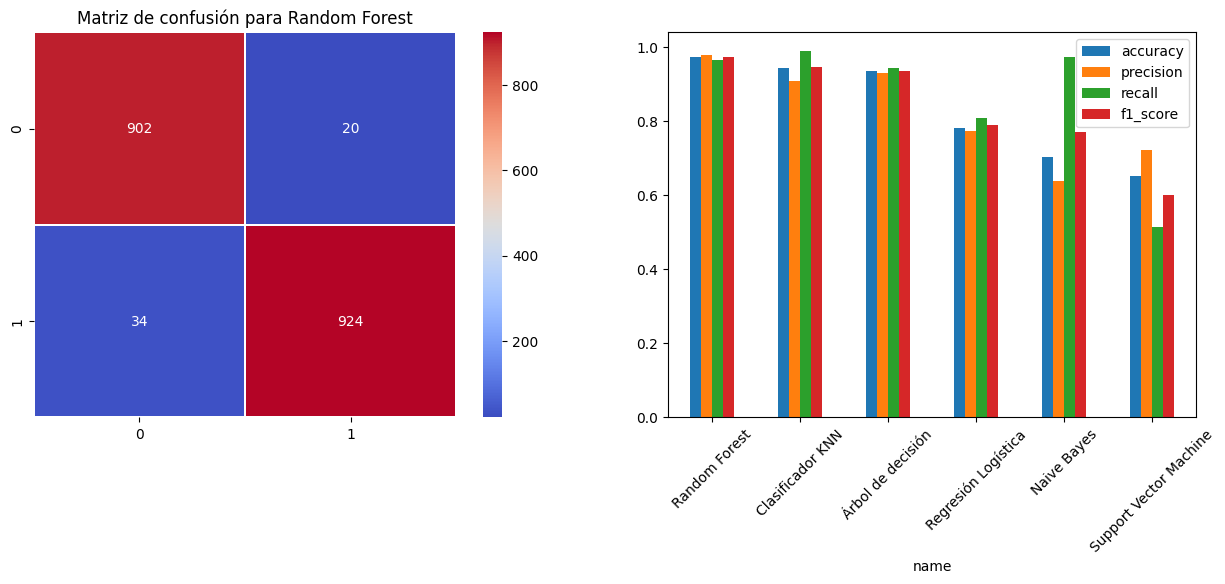

In [208]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)
axs[0].set_title(f"Matriz de confusión para {best_predictor.name}")
sns.heatmap(best_predictor.confusion_matrix, annot=True , cmap='coolwarm' , linewidths = 0.01 , fmt='g', ax=axs[0])
axs[1] = df_results.plot.bar(x="name", ax=axs[1], rot=45)

### Clustering

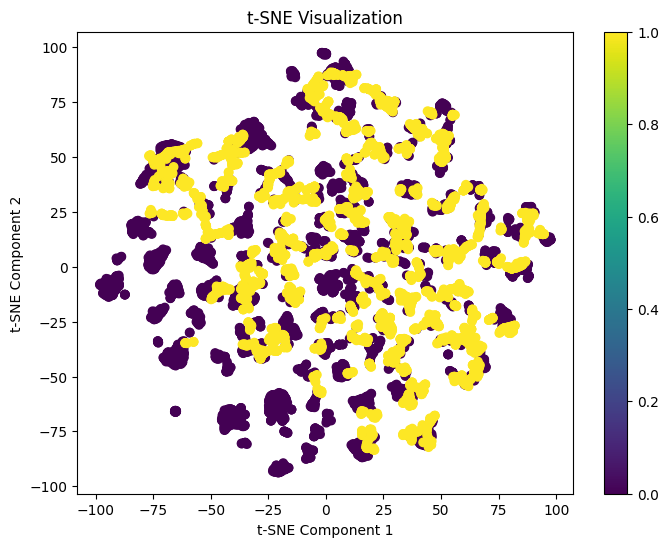

In [209]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smote)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_smote, cmap="viridis")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization")
plt.colorbar()
plt.show()

In [210]:
print(X_tsne.shape, y_smote.shape)

(9400, 2) (9400,)


In [211]:
# Vamos a calcular diferentes modelos de K-means, cambiando la cantidad de cluster en cada iteración
wcss = []
for i in range(1, 20):
    kmeans = KMeans(
        n_clusters=i,
        init="k-means++",  # Esta forma busca una inicialización que converga más rapido que incializar al azar
        max_iter=300,  # El numero maximo de iteraciones
        n_init=10,  # Cuanta veces repite la ejecucion del algoritmo hasta que se quede con el mejor caso
        random_state=42,
    )
    kmeans.fit(X_tsne)
    wcss.append(kmeans.inertia_)  # SKlearn le llama inercia a WCSS:w

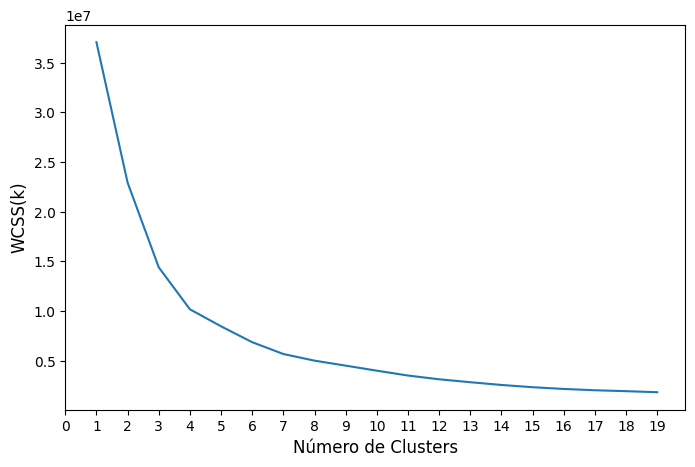

In [212]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20), wcss)
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("WCSS(k)", fontsize=12)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

In [213]:
kmeans = KMeans(
    n_clusters=4, init="k-means++", max_iter=300, n_init=10, random_state=42
)
y_kmeans = kmeans.fit_predict(X_tsne)

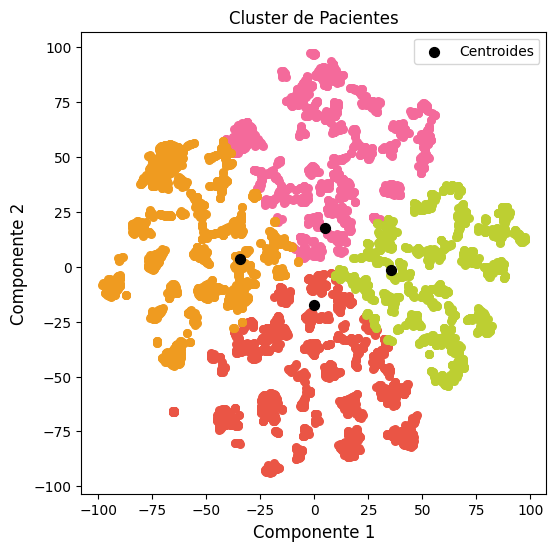

In [214]:
# Visualización de los clusters
plt.figure(figsize=(6, 6)) 
plt.scatter(X_tsne[y_kmeans == 0, 0], X_tsne[y_kmeans == 0, 1], s = 30, c = "#ea5545")
plt.scatter(X_tsne[y_kmeans == 1, 0], X_tsne[y_kmeans == 1, 1], s = 30, c = "#f46a9b")
plt.scatter(X_tsne[y_kmeans == 2, 0], X_tsne[y_kmeans == 2, 1], s = 30, c = "#ef9b20")
plt.scatter(X_tsne[y_kmeans == 3, 0], X_tsne[y_kmeans == 3, 1], s = 30, c = "#bdcf32")

# Usar solo las primeras dos dimensiones para la transformación inversa
re_scaled_centroids = (kmeans.cluster_centers_ * scaler.scale_[:2]) + scaler.mean_[:2]

plt.scatter(re_scaled_centroids[:,0], re_scaled_centroids[:,1], s=50, c="black", label="Centroides")
plt.title("Cluster de Pacientes", fontsize=12)
plt.xlabel("Componente 1", fontsize=12)
plt.ylabel("Componente 2", fontsize=12)
plt.legend()
plt.show()

### Redes Feed-Forward

In [215]:
X = df.drop("stroke", axis=1).values
y = df["stroke"].values
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)  # over-sampling due to class imbalance
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [216]:
def reset_weights(m):
    """
    Try resetting model weights to avoid
    weight leakage.
    """
    for layer in m.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()


class BinaryNetwork(torch.nn.Module):
    """
    Red neuronal para clasificación binaria.

    Esta red neuronal consiste en múltiples capas totalmente conectadas con normalización por lotes
    y funciones de activación ReLU. La capa de salida utiliza una función de activación sigmoide
    para producir probabilidades de clasificación binaria.

    Args:
        input_size (int): El número de características de entrada.
    """

    def __init__(self, input_size):
        """
        Inicializa el modelo BinaryNetwork.

        Args:
            input_size (int): El número de características de entrada.
        """
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.BatchNorm1d(input_size),
            torch.nn.Linear(input_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
        )

    def forward(self, x):
        """
        Paso hacia adelante a través de la red.
        Args:
            x (torch.Tensor): Tensor de entrada de forma (batch_size, input_size).
        Returns:
            torch.Tensor: Tensor de salida conteniendo probabilidades de clasificación binaria.
        """
        x = self.layers(x)
        return torch.sigmoid(x)  # Escalamos los valores entre 0 y 1

En este caso se utilizará cross-validation:

In [218]:
# tiempo de ejecución de ~15 min
batch_size = 64
input_size = 16
kfolds = 3
epochs = 1200
loss_fn = torch.nn.BCELoss()
# Define the K-fold Cross Validator
kfold = KFold(n_splits=kfolds, shuffle=True)
# performance metrics
results = []

# progress bar
progress_bar = IntProgress(min=0, max=kfolds * epochs)  # instantiate the bar
display(progress_bar)  # display the bar

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    network = BinaryNetwork(input_size=input_size)
    network.apply(reset_weights)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-5)

    for epoch in range(epochs):
        # Set current loss value
        train_loss = 0
        # Iterate over the DataLoader for training data
        for inputs, targets in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            outputs = network(inputs)
            # Compute loss
            loss = loss_fn(outputs, targets.unsqueeze(1))
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        results.append({
            "fold": fold,
            "epoch": epoch,
            "type": "train",
            "loss": train_loss,
        })

        # Saving the model
        save_path = f"./model-fold-{fold}.pth"
        torch.save(network.state_dict(), save_path)

        # Evaluation for this fold
        test_loss = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for inputs, targets in test_loader:
                # Generate outputs
                outputs = network(inputs)
                test_loss += loss.item() * inputs.size(0)
                test_predictions.extend(outputs.round().squeeze().tolist())
                test_targets.extend(targets.tolist())

        test_loss /= len(test_loader.dataset)
        results.append({
            "fold": fold,
            "epoch": epoch,
            "type": "test",
            "loss": test_loss
        })

        # Get test accuracy
        results.append({
            "fold": fold,
            "epoch": epoch,
            "type": "accuracies",
            "loss": accuracy_score(test_targets, test_predictions)
        })

        # print(
        #     f"Época: {epoch}/{epochs}, Costo de Entrenamiento: {train_loss:.4f}, "
        #     f"Costo de Validación: {test_loss:.4f}, Exactitud en Validación: {test_accuracies[fold][-1]:.4f}"
        # )

        progress_bar.value += 1

IntProgress(value=0, max=3600)

Análisis de resultados:

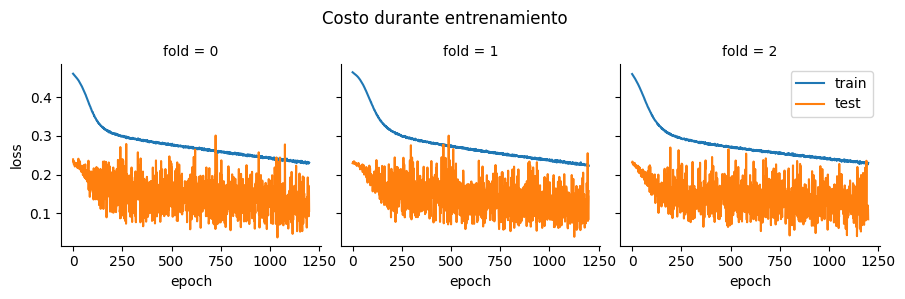

In [219]:
results_df = pd.DataFrame(results)
g = sns.FacetGrid(data=results_df[results_df["type"] != "accuracies"], col="fold", hue="type")
g.map_dataframe(sns.lineplot, x="epoch", y="loss")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Costo durante entrenamiento")
plt.legend()

Test Accuracy: 0.8415
F1-score: 0.8448


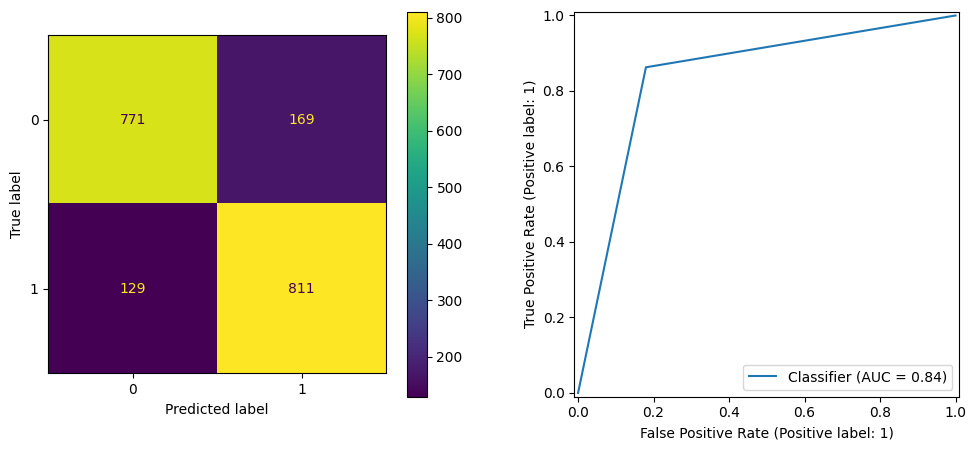

In [220]:
fig, axs = plt.subplots(figsize=(5,5), ncols=2)
fig.set_size_inches(12, 5)
# Evaluacion en el conjunto de prueba
network.eval()
with torch.no_grad():
    valid_outputs = network(X_valid_tensor)
    valid_outputs = (valid_outputs >= 0.5).float()
    valid_accuracy = accuracy_score(y_valid_tensor, valid_outputs)
    print(f'Test Accuracy: {valid_accuracy:.4f}')
    print(f'F1-score: {f1_score(y_valid_tensor, valid_outputs):.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_valid_tensor, valid_outputs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0])
    svc_disp = RocCurveDisplay.from_predictions(y_valid_tensor, valid_outputs, ax=axs[1])
    plt.show()